In [1]:
# Load python modules
from tensorflow.keras import datasets, layers, models, regularizers
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
from tensorflow.keras.layers import Resizing, Rescaling
import seaborn as sns
import tensorflow_datasets as tfds
from sklearn.utils import shuffle 
import matplotlib.pyplot as plt
from datetime import datetime
import tensorflow as tf
from tqdm import tqdm  # Perform iterature with progress bar
import numpy as np
import PIL.Image
import PIL
import cv2
import os

In [2]:
#Class labelsb
class_names = ['Glass', 'Metal', 'Paper', 'Textile']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}
nb_classes = len(class_names)
IMAGE_SIZE = (64, 64)

In [3]:
print('Number of classes:', nb_classes)

Number of classes: 4


In [4]:
resize_layer_32 = tf.keras.Sequential([
    Resizing(32, 32),
])

In [5]:
def load_data():
    """
        Load the data from local folder
        
    """
    datasets = ['C:/Mani/Dataset/dataset1/train_ds',
               'C:/Mani/Dataset/dataset1/test_ds']
    
    output = []
    
    # Iterate through training and test sets
    for dataset in datasets:
        
        #Empty Image and Labels list
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE) 
                
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

In [6]:
#Prepare dataset for training and testing
(train_images, train_labels), (test_images, test_labels) = load_data()

Loading C:/Mani/Dataset/dataset1/train_ds


100%|███████████████████████████████████████████████████████████████████████████████| 270/270 [00:01<00:00, 185.99it/s]


Loading C:/Mani/Dataset/dataset1/test_ds


100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 176.77it/s]


In [7]:
#Check the training and testing image shape
train_images.shape, test_images.shape

((1080, 64, 64, 3), (200, 64, 64, 3))

In [8]:
# Shuffle only the training dataset
np.random.seed(321)
train_images, train_labels = shuffle(train_images, train_labels)

In [9]:
#Check the number of training dataset
print('No of training images:', train_images.shape[0])

No of training images: 1080


In [10]:
#Normalise train and test image dataset from 0,255 to 0,1
train_images = train_images / 255.0 
test_images = test_images / 255.0

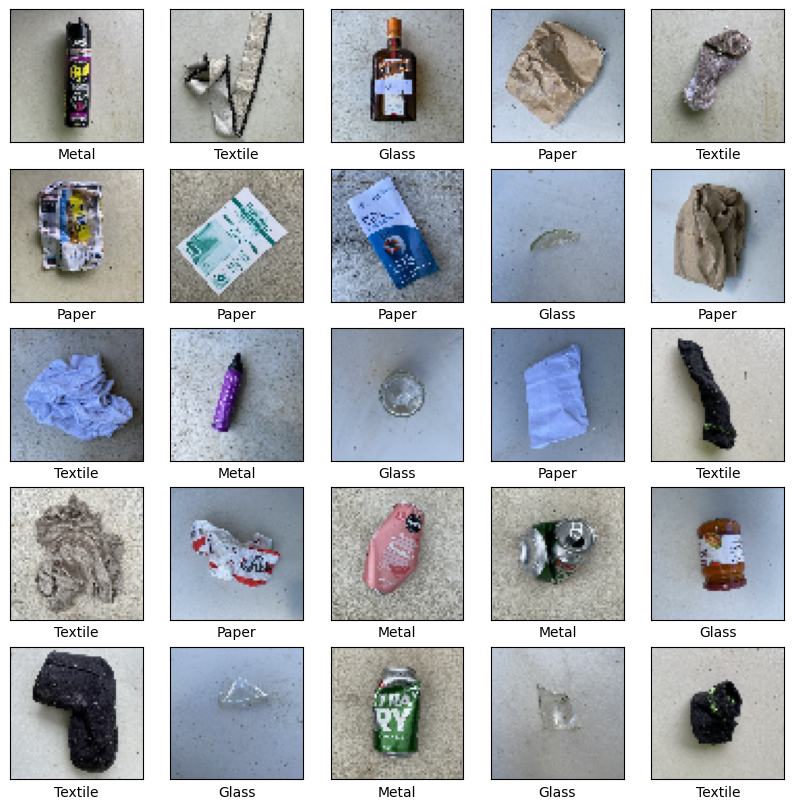

In [11]:
#Display 25 images 
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    plt.xlabel(class_names[train_labels[i]])
plt.show()

In [12]:
#Sequential Model 1
# Experience 3 with Batch Normalisation
model_1 = tf.keras.models.Sequential([
    tf.keras.layers.Input((None,None,3)),
    resize_layer_32,
    
    # Block 1
    tf.keras.layers.Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(0.05), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    # Block 2
    tf.keras.layers.Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(0.05), activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, kernel_regularizer=regularizers.l2(0.05), activation = 'relu'),                                                      
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(4, activation='softmax')
       
])

model_1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         524,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 544,708 (2.08 MB)

 Trainable params: 544,516 (2.08 MB)

 Non-trainable params: 192 (768.00 B)

In [13]:
#Sequential Model 2 
# With Batch Normalisation

model_2 = tf.keras.models.Sequential([
    tf.keras.layers.Input((64,64,3)),
    
    #Block 1
    tf.keras.layers.Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(0.05), activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    #Block2
    tf.keras.layers.Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(0.05), activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    #Block 3
    tf.keras.layers.Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(0.05), activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    #Block 4
    tf.keras.layers.Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(0.05), activation = 'relu'),
    #tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
       
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(4, activation='softmax')
       
])

model_2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64, 64, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 8, 8, 64)            │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 300,164 (1.15 MB)

 Trainable params: 299,460 (1.14 MB)

 Non-trainable params: 704 (2.75 KB)

In [14]:
#Sequential Model 3 
# Model 3 with batch normalisation

model_3 = tf.keras.models.Sequential([
    tf.keras.layers.Input((64,64,3)),
    
    # Block 1
    tf.keras.layers.Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(0.05), activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    # Block 2
    tf.keras.layers.Conv2D(64, (5,5), padding='same', kernel_regularizer=regularizers.l2(0.05), activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    # Block 3
    tf.keras.layers.Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(0.05), activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    # Block 4
    tf.keras.layers.Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(0.05), activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    #Block 5
    tf.keras.layers.Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(0.05), activation = 'relu'),
    #tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    #tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(4, activation='softmax')      
])

model_3.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 64, 64, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 32, 32, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 8, 8, 64)            │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 8, 8, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 4, 4, 32)            │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 2, 2, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 2, 2, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 236,452 (923.64 KB)

 Trainable params: 235,876 (921.39 KB)

 Non-trainable params: 576 (2.25 KB)

In [15]:
# Add callbacks to save the model weight with best accuracy during training

#import ModelCheckpoint package
#from tensorflow.keras.callbacks import ModelCheckpoint
# Source: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint

checkpoint_filepath1 = 'C:/Mani/ModelCheckpoint/model1.keras'
model_checkpoint_callback1 = ModelCheckpoint(
    filepath=checkpoint_filepath1,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)


checkpoint_filepath2 = 'C:/Mani/ModelCheckpoint/model2.keras'
model_checkpoint_callback2 = ModelCheckpoint(
    filepath=checkpoint_filepath2,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

checkpoint_filepath3 = 'C:/Mani/ModelCheckpoint/model3.keras'
model_checkpoint_callback3 = ModelCheckpoint(
    filepath=checkpoint_filepath3,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

In [16]:
model_1.compile(optimizer = tf.keras.optimizers.Adam(0.0015),
                loss = 'sparse_categorical_crossentropy', 
                metrics=['accuracy'])


model_2.compile(optimizer = tf.keras.optimizers.Adam(0.001),
                loss = 'sparse_categorical_crossentropy',
                metrics=['accuracy'])


model_3.compile(optimizer = tf.keras.optimizers.Adam(0.00098),
                loss = 'sparse_categorical_crossentropy',
                metrics=['accuracy'])
               

In [17]:
#Learning rate scheduler for Model 1 and 2

def scheduler1(epoch, lr):
    if epoch <= 30:
        return lr
    else:
        return lr * 0.95
        
    
lr_callback1 = LearningRateScheduler(scheduler1, verbose=1)

In [18]:
#Learning rate scheduler for Model 1 and 2

def scheduler2(epoch, lr):
    if epoch <= 45:
        return lr
    else:
        return lr * 0.95
        
    
lr_callback2 = LearningRateScheduler(scheduler2, verbose=1)

In [19]:
# Set number of epochs
epochs = 150
batch_size = 64


In [20]:
# Register the model training start time.
start_time = datetime.now()
print('Time model start:', start_time)

history1 = model_1.fit(train_images, train_labels,
                      batch_size=batch_size, epochs=epochs,
                      validation_split = 0.2, verbose=1,
                      callbacks=[lr_callback1, model_checkpoint_callback1])

# Register the model training end time.
end_time = datetime.now()
print('Time model end:', end_time)
print('Model_1_training_time', end_time - start_time)


Time model start: 2024-11-08 23:13:06.201294

Epoch 1: LearningRateScheduler setting learning rate to 0.001500000013038516.
Epoch 1/150
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.3927 - loss: 18.1140
Epoch 1: val_accuracy improved from -inf to 0.33333, saving model to C:/Mani/ModelCheckpoint/model1.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.4012 - loss: 17.8118 - val_accuracy: 0.3333 - val_loss: 12.1915 - learning_rate: 0.0015

Epoch 2: LearningRateScheduler setting learning rate to 0.001500000013038516.
Epoch 2/150
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.6080 - loss: 10.9184
Epoch 2: val_accuracy did not improve from 0.33333
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.6106 - loss: 10.7988 - val_accuracy: 0.3194 - val_loss: 8.7072 - learning_rate: 0.0015

Epoch 3: LearningRateScheduler setting learning rate to 0.001500000013038516.
Epoch 3/150
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.6867 - loss: 7.5650
Epoch 3: val_accur


Epoch 20: LearningRateScheduler setting learning rate to 0.001500000013038516.
Epoch 20/150
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8826 - loss: 1.0974
Epoch 20: val_accuracy did not improve from 0.40741
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.8830 - loss: 1.0971 - val_accuracy: 0.2639 - val_loss: 3.1467 - learning_rate: 0.0015

Epoch 21: LearningRateScheduler setting learning rate to 0.001500000013038516.
Epoch 21/150
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8988 - loss: 1.0447
Epoch 21: val_accuracy did not improve from 0.40741
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.8973 - loss: 1.0481 - val_accuracy: 0.2639 - val_loss: 3.2540 - learning_rate: 0.0015

Epoch 22: LearningRateScheduler setting learning rate to 0.001500000013038516.
Epoch 22/150
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9089 - loss: 1.0165
Epoch 22: val_accuracy did not improve from 0.40741
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.9076 - lo

Epoch 39/150
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9707 - loss: 0.6488
Epoch 39: val_accuracy did not improve from 0.40741
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.9700 - loss: 0.6493 - val_accuracy: 0.2917 - val_loss: 2.8602 - learning_rate: 9.9513e-04

Epoch 40: LearningRateScheduler setting learning rate to 0.0009453740960452705.
Epoch 40/150
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9665 - loss: 0.6039
Epoch 40: val_accuracy did not improve from 0.40741
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.9657 - loss: 0.6036 - val_accuracy: 0.3333 - val_loss: 2.2981 - learning_rate: 9.4537e-04

Epoch 41: LearningRateScheduler setting learning rate to 0.0008981053746538237.
Epoch 41/150
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9811 - loss: 0.5476
Epoch 41: val_accuracy did not improve from 0.40741
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.9804 - loss: 0.5471 - val_accuracy: 0.3380 - val_loss: 2.4328 - learning_rate: 


Epoch 58: LearningRateScheduler setting learning rate to 0.0003755161000299267.
Epoch 58/150
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.9953 - loss: 0.2537
Epoch 58: val_accuracy did not improve from 0.65278
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.9953 - loss: 0.2539 - val_accuracy: 0.5880 - val_loss: 1.3445 - learning_rate: 3.7552e-04

Epoch 59: LearningRateScheduler setting learning rate to 0.00035674029641086236.
Epoch 59/150
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9919 - loss: 0.2443
Epoch 59: val_accuracy did not improve from 0.65278
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.9924 - loss: 0.2450 - val_accuracy: 0.5972 - val_loss: 1.3076 - learning_rate: 3.5674e-04

Epoch 60: LearningRateScheduler setting learning rate to 0.0003389032746781595.
Epoch 60/150
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9972 - loss: 0.2428
Epoch 60: val_accuracy did not improve from 0.65278
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy:

Epoch 76/150
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.9994 - loss: 0.1902
Epoch 76: val_accuracy did not improve from 0.81481
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.9994 - loss: 0.1901 - val_accuracy: 0.7870 - val_loss: 0.8166 - learning_rate: 1.4916e-04

Epoch 77: LearningRateScheduler setting learning rate to 0.00014170235735946334.
Epoch 77/150
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.9994 - loss: 0.1870
Epoch 77: val_accuracy did not improve from 0.81481
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.9992 - loss: 0.1869 - val_accuracy: 0.8009 - val_loss: 0.7119 - learning_rate: 1.4170e-04

Epoch 78: LearningRateScheduler setting learning rate to 0.0001346172415651381.
Epoch 78/150
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9943 - loss: 0.1933
Epoch 78: val_accuracy did not improve from 0.81481
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.9946 - loss: 0.1929 - val_accuracy: 0.7917 - val_loss: 0.7193 - learning_rate:


Epoch 95: LearningRateScheduler setting learning rate to 5.628619710478233e-05.
Epoch 95/150
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 0.1616
Epoch 95: val_accuracy did not improve from 0.82407
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 1.0000 - loss: 0.1619 - val_accuracy: 0.8102 - val_loss: 0.6157 - learning_rate: 5.6286e-05

Epoch 96: LearningRateScheduler setting learning rate to 5.3471887076739216e-05.
Epoch 96/150
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9991 - loss: 0.1675
Epoch 96: val_accuracy did not improve from 0.82407
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.9991 - loss: 0.1671 - val_accuracy: 0.8102 - val_loss: 0.6061 - learning_rate: 5.3472e-05

Epoch 97: LearningRateScheduler setting learning rate to 5.0798291340470314e-05.
Epoch 97/150
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 0.1585
Epoch 97: val_accuracy did not improve from 0.82407
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy


Epoch 114: LearningRateScheduler setting learning rate to 2.1239800207695226e-05.
Epoch 114/150
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9987 - loss: 0.1556
Epoch 114: val_accuracy did not improve from 0.82407
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.9987 - loss: 0.1557 - val_accuracy: 0.8102 - val_loss: 0.6005 - learning_rate: 2.1240e-05

Epoch 115: LearningRateScheduler setting learning rate to 2.017781080212444e-05.
Epoch 115/150
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 0.1576
Epoch 115: val_accuracy did not improve from 0.82407
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 1.0000 - loss: 0.1575 - val_accuracy: 0.8102 - val_loss: 0.6055 - learning_rate: 2.0178e-05

Epoch 116: LearningRateScheduler setting learning rate to 1.9168920607626203e-05.
Epoch 116/150
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9997 - loss: 0.1562
Epoch 116: val_accuracy did not improve from 0.82407
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step -


Epoch 133: LearningRateScheduler setting learning rate to 8.014915329113137e-06.
Epoch 133/150
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 1.0000 - loss: 0.1502
Epoch 133: val_accuracy did not improve from 0.82407
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 1.0000 - loss: 0.1503 - val_accuracy: 0.8148 - val_loss: 0.6016 - learning_rate: 8.0149e-06

Epoch 134: LearningRateScheduler setting learning rate to 7.6141699082654665e-06.
Epoch 134/150
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9994 - loss: 0.1559
Epoch 134: val_accuracy did not improve from 0.82407
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.9994 - loss: 0.1557 - val_accuracy: 0.8056 - val_loss: 0.6039 - learning_rate: 7.6142e-06

Epoch 135: LearningRateScheduler setting learning rate to 7.233461542455188e-06.
Epoch 135/150
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 0.1528
Epoch 135: val_accuracy did not improve from 0.82407
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - 

In [21]:
# Register the model training start time.
start_time = datetime.now()
print('Time model start:', start_time)


history2 = model_2.fit(train_images, train_labels,
                       batch_size=batch_size, epochs= epochs, 
                       validation_split = 0.2, verbose=1,
                       callbacks=[lr_callback1, model_checkpoint_callback2])


# Register the model training end time.
end_time = datetime.now()
print('Time model end:', end_time)
print('Model_2_training_time', end_time - start_time)


Time model start: 2024-11-08 23:15:36.517451

Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.4780 - loss: 12.1248
Epoch 1: val_accuracy improved from -inf to 0.26389, saving model to C:/Mani/ModelCheckpoint/model2.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 350ms/step - accuracy: 0.4810 - loss: 12.0989 - val_accuracy: 0.2639 - val_loss: 11.2531 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.6312 - loss: 10.4937
Epoch 2: val_accuracy did not improve from 0.26389
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 321ms/step - accuracy: 0.6322 - loss: 10.4700 - val_accuracy: 0.2639 - val_loss: 10.0433 - learning_rate: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - accuracy: 0.6578 - loss: 8.9818
Epoch 3: 


Epoch 20: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 20/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - accuracy: 0.8946 - loss: 0.9075
Epoch 20: val_accuracy did not improve from 0.26389
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 317ms/step - accuracy: 0.8947 - loss: 0.9075 - val_accuracy: 0.2639 - val_loss: 6.6944 - learning_rate: 0.0010

Epoch 21: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 21/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - accuracy: 0.9275 - loss: 0.8499
Epoch 21: val_accuracy did not improve from 0.26389
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 327ms/step - accuracy: 0.9270 - loss: 0.8501 - val_accuracy: 0.2639 - val_loss: 6.2398 - learning_rate: 0.0010

Epoch 22: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 22/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - accuracy: 0.9059 - loss: 0.8397
Epoch 22: val_accuracy did not improve from 0.26389
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 319ms/step - accuracy: 0.


Epoch 39: LearningRateScheduler setting learning rate to 0.0006634203542489559.
Epoch 39/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.9621 - loss: 0.4672
Epoch 39: val_accuracy did not improve from 0.36574
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 318ms/step - accuracy: 0.9626 - loss: 0.4666 - val_accuracy: 0.2824 - val_loss: 3.0015 - learning_rate: 6.6342e-04

Epoch 40: LearningRateScheduler setting learning rate to 0.0006302493420662358.
Epoch 40/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - accuracy: 0.9869 - loss: 0.4182
Epoch 40: val_accuracy improved from 0.36574 to 0.42593, saving model to C:/Mani/ModelCheckpoint/model2.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 332ms/step - accuracy: 0.9860 - loss: 0.4187 - val_accuracy: 0.4259 - val_loss: 2.3358 - learning_rate: 6.3025e-04

Epoch 41: LearningRateScheduler setting learning rate to 0.0005987368611386045.
Epoch 41/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.9759 - loss: 0.4131
Epoch 41: val_accuracy did not improve fr


Epoch 57: LearningRateScheduler setting learning rate to 0.0002635200624354184.
Epoch 57/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.9877 - loss: 0.2655
Epoch 57: val_accuracy improved from 0.65278 to 0.66204, saving model to C:/Mani/ModelCheckpoint/model2.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 323ms/step - accuracy: 0.9876 - loss: 0.2657 - val_accuracy: 0.6620 - val_loss: 1.2533 - learning_rate: 2.6352e-04

Epoch 58: LearningRateScheduler setting learning rate to 0.0002503440482541919.
Epoch 58/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.9991 - loss: 0.2429
Epoch 58: val_accuracy improved from 0.66204 to 0.70833, saving model to C:/Mani/ModelCheckpoint/model2.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 318ms/step - accuracy: 0.9990 - loss: 0.2431 - val_accuracy: 0.7083 - val_loss: 1.1411 - learning_rate: 2.5034e-04

Epoch 59: LearningRateScheduler setting learning rate to 0.00023782684584148226.
Epoch 59/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.99

Epoch 75/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 1.0000 - loss: 0.1491
Epoch 75: val_accuracy did not improve from 0.80093
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 312ms/step - accuracy: 1.0000 - loss: 0.1491 - val_accuracy: 0.7963 - val_loss: 0.7627 - learning_rate: 1.0467e-04

Epoch 76: LearningRateScheduler setting learning rate to 9.944023768184706e-05.
Epoch 76/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.9980 - loss: 0.1492
Epoch 76: val_accuracy improved from 0.80093 to 0.81019, saving model to C:/Mani/ModelCheckpoint/model2.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 321ms/step - accuracy: 0.9979 - loss: 0.1492 - val_accuracy: 0.8102 - val_loss: 0.7223 - learning_rate: 9.9440e-05

Epoch 77: LearningRateScheduler setting learning rate to 9.446822441532275e-05.
Epoch 77/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.9997 - loss: 0.1447
Epoch 77: val_accuracy improved from 0.81019 to 0.81944, saving model to C:/Mani/ModelCheckpoint/model2.keras
14/14 ━━━━━━

Epoch 93/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 1.0000 - loss: 0.1221
Epoch 93: val_accuracy improved from 0.84722 to 0.85648, saving model to C:/Mani/ModelCheckpoint/model2.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 318ms/step - accuracy: 1.0000 - loss: 0.1221 - val_accuracy: 0.8565 - val_loss: 0.6824 - learning_rate: 4.1578e-05

Epoch 94: LearningRateScheduler setting learning rate to 3.949908405047608e-05.
Epoch 94/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 1.0000 - loss: 0.1210
Epoch 94: val_accuracy improved from 0.85648 to 0.86111, saving model to C:/Mani/ModelCheckpoint/model2.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 318ms/step - accuracy: 1.0000 - loss: 0.1210 - val_accuracy: 0.8611 - val_loss: 0.6447 - learning_rate: 3.9499e-05

Epoch 95: LearningRateScheduler setting learning rate to 3.752413140318822e-05.
Epoch 95/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.9964 - loss: 0.1230
Epoch 95: val_accuracy improved from 0.86111 to 0.86574, saving 

14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 314ms/step - accuracy: 1.0000 - loss: 0.1105 - val_accuracy: 0.8611 - val_loss: 0.5871 - learning_rate: 1.6515e-05

Epoch 112: LearningRateScheduler setting learning rate to 1.568960378790507e-05.
Epoch 112/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 1.0000 - loss: 0.1099
Epoch 112: val_accuracy did not improve from 0.86574
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 312ms/step - accuracy: 1.0000 - loss: 0.1098 - val_accuracy: 0.8565 - val_loss: 0.6072 - learning_rate: 1.5690e-05

Epoch 113: LearningRateScheduler setting learning rate to 1.490512377131381e-05.
Epoch 113/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 1.0000 - loss: 0.1104
Epoch 113: val_accuracy did not improve from 0.86574
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 312ms/step - accuracy: 1.0000 - loss: 0.1104 - val_accuracy: 0.8565 - val_loss: 0.6054 - learning_rate: 1.4905e-05

Epoch 114: LearningRateScheduler setting learning rate to 1.4159867669150115e-05.
Epoch 114/150
14/14 ━━━━━━━━━━━━━━


Epoch 149: LearningRateScheduler setting learning rate to 2.3517189220001454e-06.
Epoch 149/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.9994 - loss: 0.1055
Epoch 149: val_accuracy did not improve from 0.86574
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 313ms/step - accuracy: 0.9994 - loss: 0.1054 - val_accuracy: 0.8519 - val_loss: 0.5920 - learning_rate: 2.3517e-06

Epoch 150: LearningRateScheduler setting learning rate to 2.2341329326991397e-06.
Epoch 150/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 1.0000 - loss: 0.1020
Epoch 150: val_accuracy did not improve from 0.86574
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 311ms/step - accuracy: 1.0000 - loss: 0.1021 - val_accuracy: 0.8565 - val_loss: 0.5932 - learning_rate: 2.2341e-06
Time model end: 2024-11-08 23:26:58.101426
Model_2_training_time 0:11:21.583975


In [22]:
# Register the model training start time.
start_time = datetime.now()
print('Time model start:', start_time)

history3 = model_3.fit(train_images, train_labels,
                       batch_size=batch_size, epochs= epochs, 
                       validation_split = 0.2, verbose=1,
                       callbacks=[lr_callback2, model_checkpoint_callback3])


# Register the model training end time.
end_time = datetime.now()
print('Time model end:', end_time)
print('Model_3_training_time', end_time - start_time )

Time model start: 2024-11-08 23:26:58.109195

Epoch 1: LearningRateScheduler setting learning rate to 0.0009800000116229057.
Epoch 1/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.3950 - loss: 14.8259
Epoch 1: val_accuracy improved from -inf to 0.23611, saving model to C:/Mani/ModelCheckpoint/model3.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 398ms/step - accuracy: 0.3993 - loss: 14.7813 - val_accuracy: 0.2361 - val_loss: 13.2969 - learning_rate: 9.8000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.0009800000116229057.
Epoch 2/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - accuracy: 0.5573 - loss: 12.5893
Epoch 2: val_accuracy improved from 0.23611 to 0.26389, saving model to C:/Mani/ModelCheckpoint/model3.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 373ms/step - accuracy: 0.5577 - loss: 12.5638 - val_accuracy: 0.2639 - val_loss: 11.7137 - learning_rate: 9.8000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0009800000116229057.
Epoch 3/150
14/14 ━━━━━━━━━━━

14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 365ms/step - accuracy: 0.8521 - loss: 1.1886 - val_accuracy: 0.2639 - val_loss: 5.1075 - learning_rate: 9.8000e-04

Epoch 20: LearningRateScheduler setting learning rate to 0.0009800000116229057.
Epoch 20/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.8631 - loss: 1.1032
Epoch 20: val_accuracy did not improve from 0.26389
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 364ms/step - accuracy: 0.8638 - loss: 1.1017 - val_accuracy: 0.2639 - val_loss: 4.1968 - learning_rate: 9.8000e-04

Epoch 21: LearningRateScheduler setting learning rate to 0.0009800000116229057.
Epoch 21/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.8334 - loss: 1.1127
Epoch 21: val_accuracy did not improve from 0.26389
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 363ms/step - accuracy: 0.8341 - loss: 1.1115 - val_accuracy: 0.2639 - val_loss: 5.4796 - learning_rate: 9.8000e-04

Epoch 22: LearningRateScheduler setting learning rate to 0.0009800000116229057.
Epoch 22/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - accuracy: 0.9087 - loss: 0.7467
Epoch 38: val_accuracy improved from 0.33796 to 0.37037, saving model to C:/Mani/ModelCheckpoint/model3.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 367ms/step - accuracy: 0.9081 - loss: 0.7484 - val_accuracy: 0.3704 - val_loss: 2.6676 - learning_rate: 9.8000e-04

Epoch 39: LearningRateScheduler setting learning rate to 0.0009800000116229057.
Epoch 39/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - accuracy: 0.9290 - loss: 0.7083
Epoch 39: val_accuracy improved from 0.37037 to 0.43519, saving model to C:/Mani/ModelCheckpoint/model3.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 371ms/step - accuracy: 0.9289 - loss: 0.7084 - val_accuracy: 0.4352 - val_loss: 2.0830 - learning_rate: 9.8000e-04

Epoch 40: LearningRateScheduler setting learning rate to 0.0009800000116229057.
Epoch 40/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.9178 - loss: 0.7298
Epoch 40: val_accuracy improved from 0.43519 to 0.46296, saving model to C:/M

Epoch 56/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - accuracy: 0.9793 - loss: 0.4755
Epoch 56: val_accuracy did not improve from 0.74074
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 361ms/step - accuracy: 0.9785 - loss: 0.4767 - val_accuracy: 0.4583 - val_loss: 2.2045 - learning_rate: 5.8676e-04

Epoch 57: LearningRateScheduler setting learning rate to 0.000557424098951742.
Epoch 57/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.9676 - loss: 0.4885
Epoch 57: val_accuracy did not improve from 0.74074
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 361ms/step - accuracy: 0.9677 - loss: 0.4879 - val_accuracy: 0.5231 - val_loss: 1.9148 - learning_rate: 5.5742e-04

Epoch 58: LearningRateScheduler setting learning rate to 0.0005295528884744271.
Epoch 58/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.9805 - loss: 0.4331
Epoch 58: val_accuracy did not improve from 0.74074
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 362ms/step - accuracy: 0.9805 - loss: 0.4330 - val_accuracy: 0.6667 - val_loss: 1.4045 - learning_r


Epoch 75: LearningRateScheduler setting learning rate to 0.00022141677036415785.
Epoch 75/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - accuracy: 0.9875 - loss: 0.2772
Epoch 75: val_accuracy did not improve from 0.82407
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 366ms/step - accuracy: 0.9874 - loss: 0.2767 - val_accuracy: 0.8241 - val_loss: 0.7357 - learning_rate: 2.2142e-04

Epoch 76: LearningRateScheduler setting learning rate to 0.00021034593737567775.
Epoch 76/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.9893 - loss: 0.2642
Epoch 76: val_accuracy did not improve from 0.82407
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 363ms/step - accuracy: 0.9895 - loss: 0.2641 - val_accuracy: 0.7083 - val_loss: 0.9880 - learning_rate: 2.1035e-04

Epoch 77: LearningRateScheduler setting learning rate to 0.00019982864396297372.
Epoch 77/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.9913 - loss: 0.2586
Epoch 77: val_accuracy did not improve from 0.82407
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 364ms/step - a


Epoch 94: LearningRateScheduler setting learning rate to 8.355241734534501e-05.
Epoch 94/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.9972 - loss: 0.1842
Epoch 94: val_accuracy did not improve from 0.84259
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 370ms/step - accuracy: 0.9973 - loss: 0.1841 - val_accuracy: 0.8426 - val_loss: 0.6989 - learning_rate: 8.3552e-05

Epoch 95: LearningRateScheduler setting learning rate to 7.937479786050972e-05.
Epoch 95/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - accuracy: 0.9924 - loss: 0.1859
Epoch 95: val_accuracy did not improve from 0.84259
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 372ms/step - accuracy: 0.9925 - loss: 0.1860 - val_accuracy: 0.8148 - val_loss: 0.7589 - learning_rate: 7.9375e-05

Epoch 96: LearningRateScheduler setting learning rate to 7.540605693066026e-05.
Epoch 96/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.9943 - loss: 0.1828
Epoch 96: val_accuracy did not improve from 0.84259
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 365ms/step - accu

14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 363ms/step - accuracy: 1.0000 - loss: 0.1533 - val_accuracy: 0.8611 - val_loss: 0.6442 - learning_rate: 3.3188e-05

Epoch 113: LearningRateScheduler setting learning rate to 3.1528807448921724e-05.
Epoch 113/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 1.0000 - loss: 0.1520
Epoch 113: val_accuracy improved from 0.86111 to 0.86574, saving model to C:/Mani/ModelCheckpoint/model3.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 1.0000 - loss: 0.1520 - val_accuracy: 0.8657 - val_loss: 0.6454 - learning_rate: 3.1529e-05

Epoch 114: LearningRateScheduler setting learning rate to 2.9952368458907584e-05.
Epoch 114/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.9970 - loss: 0.1557
Epoch 114: val_accuracy did not improve from 0.86574
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 365ms/step - accuracy: 0.9970 - loss: 0.1557 - val_accuracy: 0.8657 - val_loss: 0.6210 - learning_rate: 2.9952e-05

Epoch 115: LearningRateScheduler setting learning rate t

Epoch 131/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - accuracy: 1.0000 - loss: 0.1421
Epoch 131: val_accuracy did not improve from 0.87037
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 366ms/step - accuracy: 1.0000 - loss: 0.1421 - val_accuracy: 0.8704 - val_loss: 0.6339 - learning_rate: 1.2524e-05

Epoch 132: LearningRateScheduler setting learning rate to 1.1897510012204293e-05.
Epoch 132/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 1.0000 - loss: 0.1416
Epoch 132: val_accuracy did not improve from 0.87037
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 365ms/step - accuracy: 1.0000 - loss: 0.1416 - val_accuracy: 0.8657 - val_loss: 0.6331 - learning_rate: 1.1898e-05

Epoch 133: LearningRateScheduler setting learning rate to 1.1302634857202064e-05.
Epoch 133/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.9996 - loss: 0.1434
Epoch 133: val_accuracy did not improve from 0.87037
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 364ms/step - accuracy: 0.9996 - loss: 0.1434 - val_accuracy: 0.8611 - val_loss: 0.6343 -


Epoch 150: LearningRateScheduler setting learning rate to 4.725861754195648e-06.
Epoch 150/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 1.0000 - loss: 0.1398
Epoch 150: val_accuracy did not improve from 0.87963
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 364ms/step - accuracy: 1.0000 - loss: 0.1398 - val_accuracy: 0.8611 - val_loss: 0.6297 - learning_rate: 4.7259e-06
Time model end: 2024-11-08 23:39:57.066249
Model_3_training_time 0:12:58.957054


Text(0.5, 1.0, 'Model 1 Accuracy (Exp:4.2)')

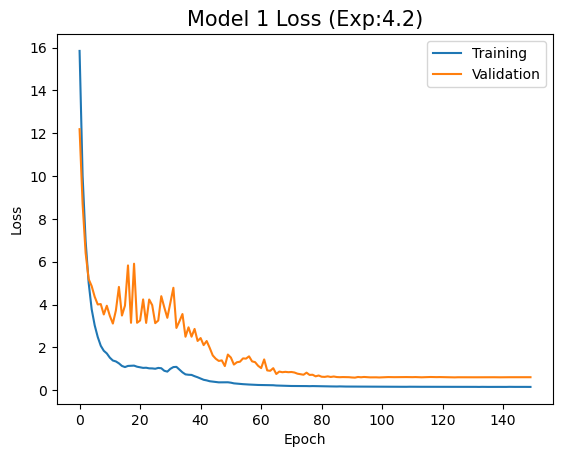

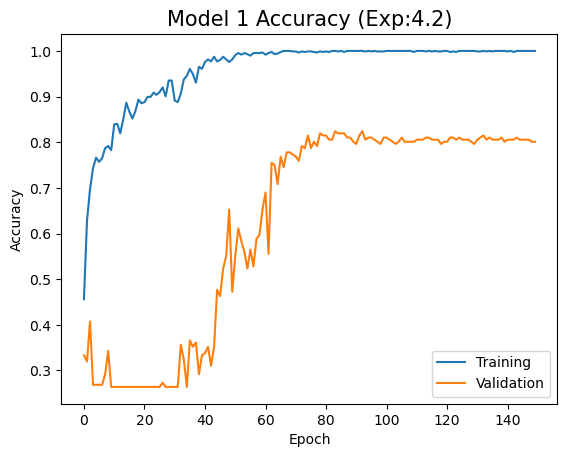

In [23]:

#Plot the training and validation loss
plt.figure()
plt.plot(history1.history['loss'], label='Training')
plt.plot(history1.history['val_loss'], label='Validation')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model 1 Loss (Exp:4.2)', fontsize = 15)

#Plot the training and validation Accuracy
plt.figure()
plt.plot(history1.history['accuracy'], label='Training')
plt.plot(history1.history['val_accuracy'], label='Validation')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model 1 Accuracy (Exp:4.2)', fontsize = 15)


Text(0.5, 1.0, 'Model 2 Accuracy (Exp:4.2)')

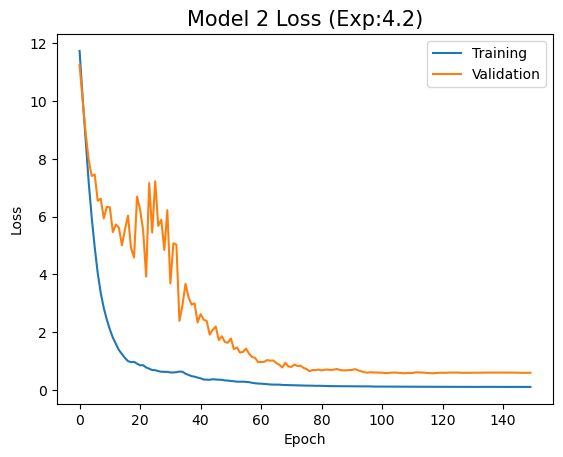

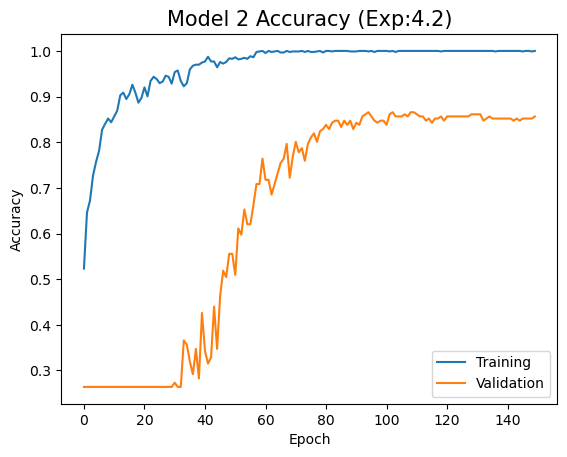

In [24]:
#Plot the training and validation loss
plt.figure()
plt.plot(history2.history['loss'], label='Training')
plt.plot(history2.history['val_loss'], label='Validation')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model 2 Loss (Exp:4.2)', fontsize = 15)

#Plot the training and validation Accuracy
plt.figure()
plt.plot(history2.history['accuracy'], label='Training')
plt.plot(history2.history['val_accuracy'], label='Validation')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model 2 Accuracy (Exp:4.2)', fontsize = 15)

Text(0.5, 1.0, 'Model 3 Accuracy (Exp:4.2)')

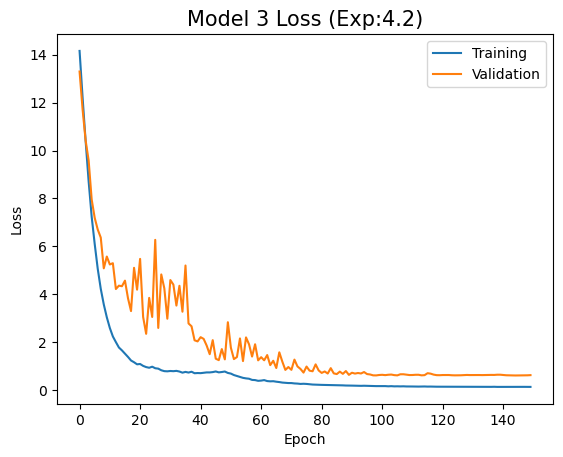

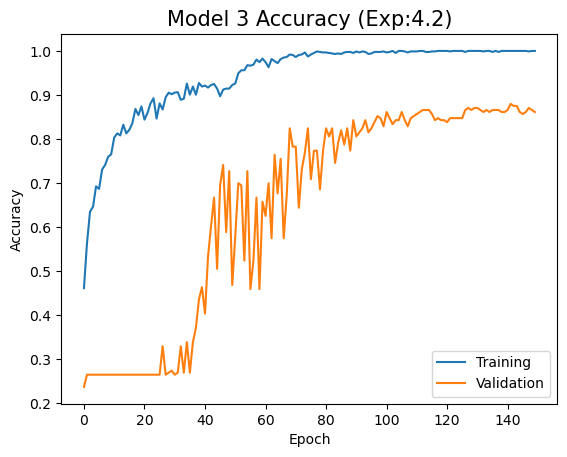

In [25]:
#Plot the training and validation loss
plt.figure()
plt.plot(history3.history['loss'], label='Training')
plt.plot(history3.history['val_loss'], label='Validation')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model 3 Loss (Exp:4.2)', fontsize = 15)

#Plot the training and validation Accuracy
plt.figure()
plt.plot(history3.history['accuracy'], label='Training')
plt.plot(history3.history['val_accuracy'], label='Validation')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model 3 Accuracy (Exp:4.2)', fontsize = 15)

In [26]:
# Evaluate the test result for model 1, 2, 3
model_1.load_weights(checkpoint_filepath1)
Test_result1 = model_1.evaluate(test_images, test_labels, batch_size = 64)

model_2.load_weights(checkpoint_filepath2)
Test_result2 = model_2.evaluate(test_images, test_labels, batch_size = 64)

model_3.load_weights(checkpoint_filepath3)
Test_result3 = model_3.evaluate(test_images, test_labels, batch_size = 64)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8331 - loss: 0.5878
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8187 - loss: 0.5980
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8702 - loss: 0.6217


In [27]:
predictions1 = model_1.predict(test_images)     # Vector of probabilities
pred_label1 = np.argmax(predictions1, axis = 1) # We take the highest probability


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


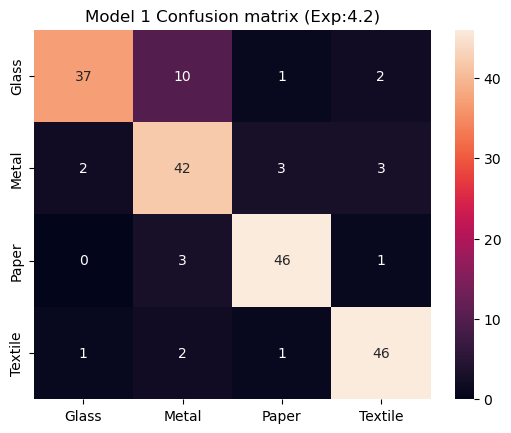

In [28]:
CM1 = confusion_matrix(test_labels, pred_label1)
ax = plt.axes()
sns.heatmap(CM1, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Model 1 Confusion matrix (Exp:4.2)')
plt.show()

In [29]:
#Obtain the model's prediction for the test_images
predictions2 = model_2.predict(test_images)
pred_label2 = np.argmax(predictions2, axis = 1)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


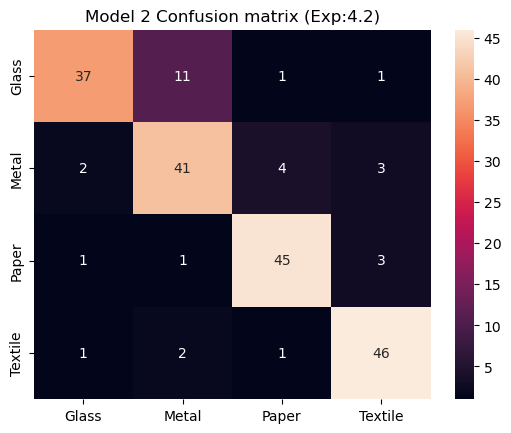

In [30]:
CM2 = confusion_matrix(test_labels, pred_label2)
ax = plt.axes()
sns.heatmap(CM2, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Model 2 Confusion matrix (Exp:4.2)')
plt.show()

In [31]:
#Obtain the model's prediction for the test_images
predictions3 = model_3.predict(test_images)
pred_label3 = np.argmax(predictions3, axis = 1)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step


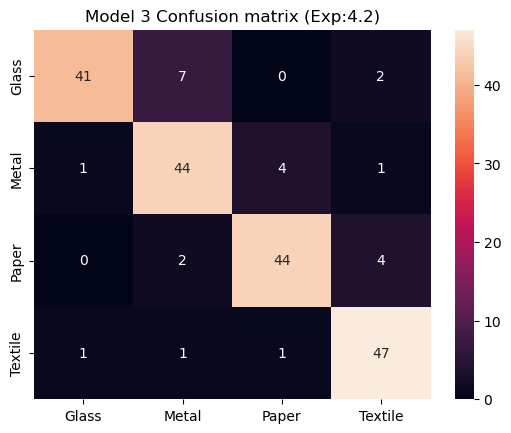

In [32]:
CM3 = confusion_matrix(test_labels, pred_label3)
ax = plt.axes()
sns.heatmap(CM3, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Model 3 Confusion matrix (Exp:4.2)')
plt.show()